In [1]:
import os
import cv2
import imghdr
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split

C:\Users\user\AppData\Local\Temp\ipykernel_17904\1228204448.py:3: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


# Cleaning Images

In [2]:
data_dir = 'Images/'

In [3]:
image_extensions = ['jpg', 'jpeg', 'png', 'bmp']

In [4]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            image_type = imghdr.what(image_path)
            if image_type not in image_extensions:
                print(f'{image_path} is not a valid image')
                os.remove(image_path)
        except Exception as e:
            print(f'Error processing {image_path}: {e}')

# Data Preprocessing

In [5]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 4589 files belonging to 14 classes.


In [6]:
data_iterators = data.as_numpy_iterator()
batch = next(data_iterators)
batch[1].max()


np.int32(13)

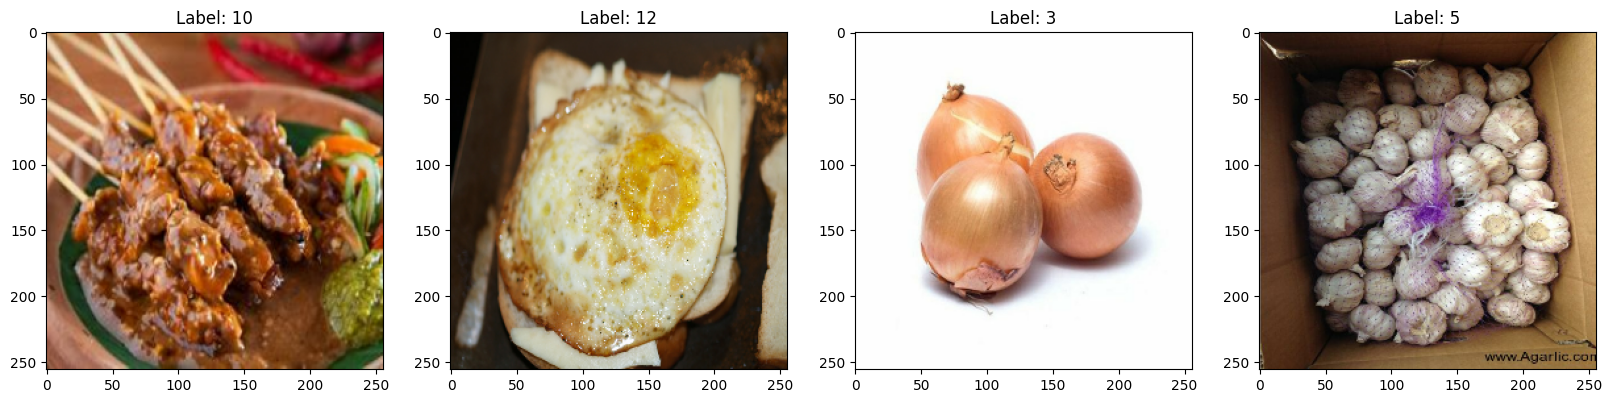

In [7]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, image in enumerate(batch[0][:4]):
    ax[idx].imshow(image.astype(int))
    ax[idx].title.set_text(f'Label: {batch[1][idx]}')

In [8]:
data_dir_path = Path(data_dir)
filepaths = list(data_dir_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(250, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [9]:
image_df['Label'].value_counts()

Label
Bawang Putih       250
Bawang Bombai      250
Telur Mata Sapi    250
Cabe Rawit         250
Sate Ayam          250
Tempe Goreng       250
Ayam Goreng        250
Pisang             250
Nasi Putih         250
Bakso              250
Alpukat            250
Mangga             250
Tahu Goreng        250
Bawang Merah       250
Name: count, dtype: int64

Split Data

In [10]:
train_df, test_df = train_test_split(
    image_df, 
    train_size=0.8, 
    shuffle=True, 
    random_state=1)

In [11]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [12]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2240 validated image filenames belonging to 14 classes.
Found 560 validated image filenames belonging to 14 classes.
Found 700 validated image filenames belonging to 14 classes.


# Pre-Trained

In [22]:
from tensorflow.keras.regularizers import l2

res_base = tf.keras.applications.ResNet152V2(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
res_base.trainable = False

inputs = res_base.input

x = res_base(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='leaky_relu', kernel_regularizer=l2(0.001))(x)
outputs = tf.keras.layers.Dense(14, activation='sigmoid', kernel_regularizer=l2(0.001))(x)
model = tf.keras.Model(inputs, outputs)
print(model.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet152v2 (Functional)        │ (None, 7, 7, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 14)             │         3,598 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,515,662 (227.03 MB)

 Trainable params: 1,184,014 (4.52 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

None


# Training

In [25]:
from tensorflow.keras.optimizers import Adamax

# Compile the model
model.compile(optimizer=Adamax(learning_rate=1e-3), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [26]:
# Define callbacks for early stopping and model checkpoint
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

# Train the model with frozen layers
history1 = model.fit(train_images, epochs=100, verbose=1, validation_data=val_images, callbacks=callbacks, shuffle=False)

Epoch 1/100
 2/70 ━━━━━━━━━━━━━━━━━━━━ 5:39 5s/step - accuracy: 0.1406 - loss: 4.5462  

c:\Users\user\Downloads\Smartbite\.conda\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4841 - loss: 2.9080
Epoch 1: val_loss improved from inf to 1.59740, saving model to best_model.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 669s 9s/step - accuracy: 0.4862 - loss: 2.8994 - val_accuracy: 0.8304 - val_loss: 1.5974
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8212 - loss: 1.6061
Epoch 2: val_loss improved from 1.59740 to 1.41229, saving model to best_model.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 562s 8s/step - accuracy: 0.8214 - loss: 1.6053 - val_accuracy: 0.8750 - val_loss: 1.4123
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8741 - loss: 1.3995
Epoch 3: val_loss improved from 1.41229 to 1.34976, saving model to best_model.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 606s 9s/step - accuracy: 0.8743 - loss: 1.3991 - val_accuracy: 0.8946 - val_loss: 1.3498
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8922 - loss: 1.3015
Epoch 4: val_loss improved from 1.34976 to 1.31821, saving model to best_mode

In [27]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

c:\Users\user\Downloads\Smartbite\.conda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Accuracy: 90.29%


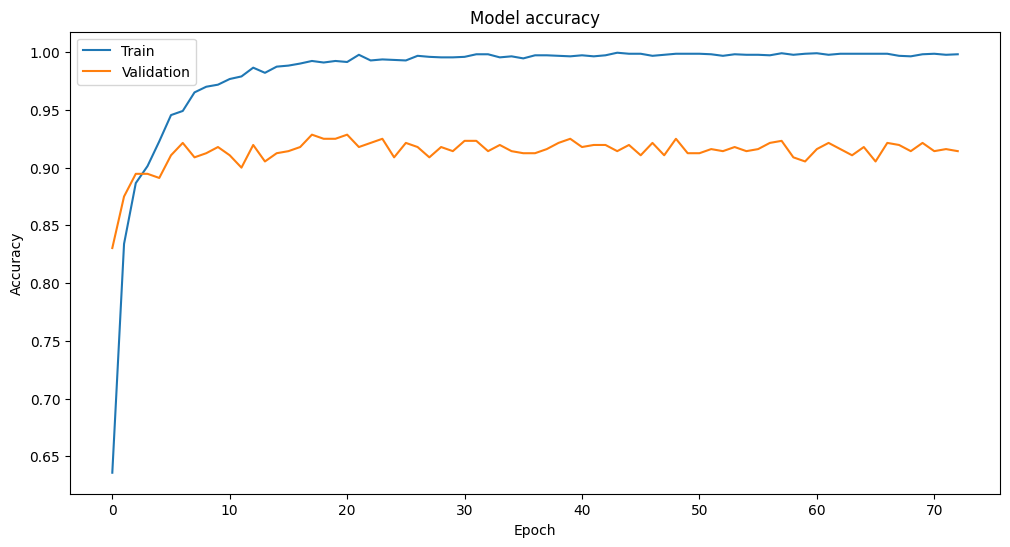

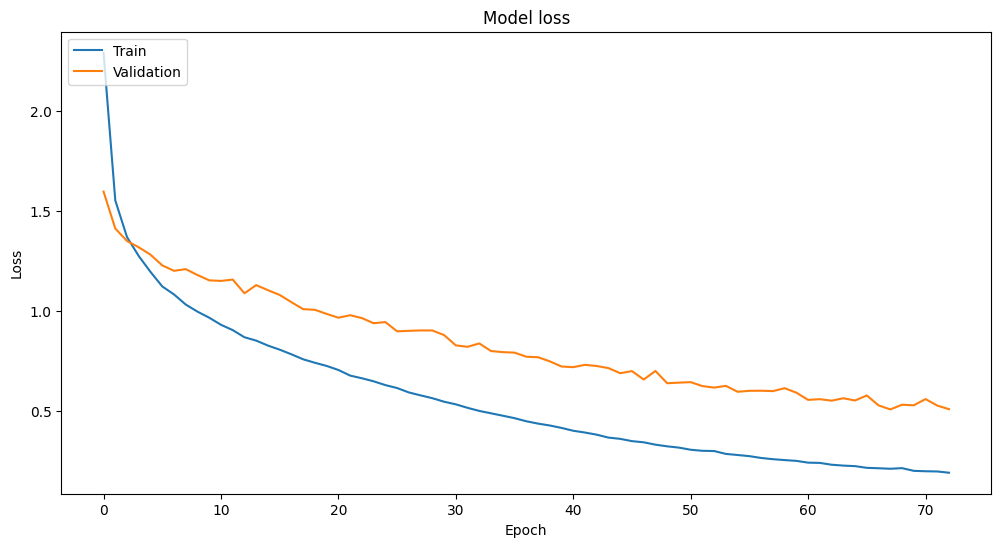

In [28]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

18/22 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step

c:\Users\user\Downloads\Smartbite\.conda\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 114s 5s/step


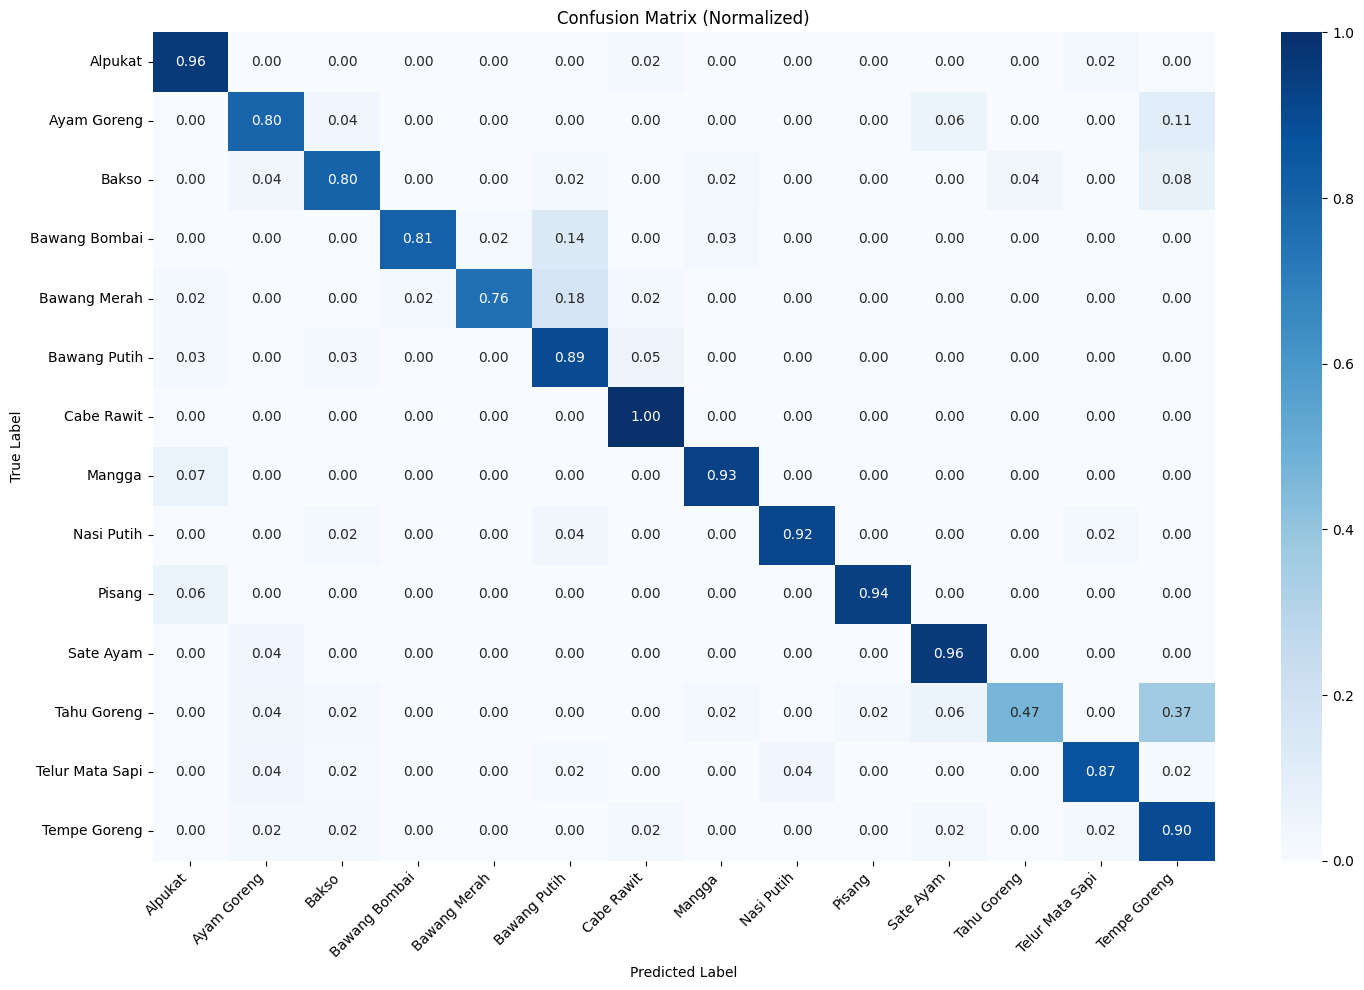


Classification Report:
                 precision    recall  f1-score   support

        Alpukat       0.86      0.96      0.91        51
    Ayam Goreng       0.83      0.80      0.81        54
          Bakso       0.85      0.80      0.83        51
  Bawang Bombai       0.98      0.81      0.89        63
   Bawang Merah       0.97      0.76      0.85        45
   Bawang Putih       0.62      0.89      0.73        38
     Cabe Rawit       0.91      1.00      0.95        48
         Mangga       0.91      0.93      0.92        45
     Nasi Putih       0.96      0.92      0.94        51
         Pisang       0.98      0.94      0.96        49
      Sate Ayam       0.88      0.96      0.92        55
    Tahu Goreng       0.92      0.47      0.62        49
Telur Mata Sapi       0.94      0.87      0.90        53
   Tempe Goreng       0.60      0.90      0.72        48

       accuracy                           0.86       700
      macro avg       0.87      0.86      0.85       700
   we

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(
    model, 
    test_generator, 
    class_names=None, 
    title='Confusion Matrix',
    normalize=True
):
    """
    Fungsi untuk membuat dan memvisualisasikan Confusion Matrix
    
    Parameters:
    - model: Model yang sudah dilatih
    - test_generator: Generator data test
    - class_names: Nama-nama kelas
    - normalize: Apakah matrix dinormalisasi
    """
    
    # Reset generator
    test_generator.reset()
    
    # Ambil semua data test
    y_true = test_generator.classes
    
    # Prediksi menggunakan model
    y_pred = model.predict(test_generator)
    
    # Konversi prediksi ke kelas
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Jika class_names tidak disediakan, gunakan indeks kelas
    if class_names is None:
        class_names = list(test_generator.class_indices.keys())
    
    # Hitung confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Normalisasi jika diminta
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title += ' (Normalized)'
    else:
        fmt = 'd'
    
    # Visualisasi
    plt.figure(figsize=(15, 10))
    
    # Confusion Matrix Heatmap
    sns.heatmap(
        cm, 
        annot=True, 
        cmap='Blues', 
        fmt=fmt,
        xticklabels=class_names, 
        yticklabels=class_names
    )
    
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Cetak classification report
    print("\nClassification Report:")
    print(classification_report(
        y_true, 
        y_pred_classes, 
        target_names=class_names
    ))

def advanced_confusion_matrix_analysis(
    model, 
    test_generator, 
    class_names=None
):
    """
    Analisis mendalam Confusion Matrix
    """
    # Reset generator
    test_generator.reset()
    
    # Ambil semua data test
    y_true = test_generator.classes
    
    # Prediksi menggunakan model
    y_pred = model.predict(test_generator)
    
    # Konversi prediksi ke kelas
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Jika class_names tidak disediakan, gunakan indeks kelas
    if class_names is None:
        class_names = list(test_generator.class_indices.keys())
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Visualisasi Detail
    plt.figure(figsize=(20, 15))
    
    # Subplot 1: Normalized Confusion Matrix
    plt.subplot(2, 2, 1)
    sns.heatmap(
        cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 
        annot=True, 
        cmap='Blues', 
        fmt='.2f',
        xticklabels=class_names, 
        yticklabels=class_names
    )
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    
    # Subplot 2: Raw Confusion Matrix
    plt.subplot(2, 2, 2)
    sns.heatmap(
        cm, 
        annot=True, 
        cmap='Reds', 
        fmt='d',
        xticklabels=class_names, 
        yticklabels=class_names
    )
    plt.title('Raw Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    
    # Subplot 3: Precision per Class
    precision_per_class = cm.diagonal() / cm.sum(axis=0)
    plt.subplot(2, 2, 3)
    plt.bar(class_names, precision_per_class)
    plt.title('Precision per Class')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Precision')
    
    # Subplot 4: Recall per Class
    recall_per_class = cm.diagonal() / cm.sum(axis=1)
    plt.subplot(2, 2, 4)
    plt.bar(class_names, recall_per_class)
    plt.title('Recall per Class')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Recall')
    
    plt.tight_layout()
    plt.show()
    
    # Identifikasi Kesalahan Terburuk
    misclassification_analysis(
        y_true, 
        y_pred_classes, 
        class_names
    )

def misclassification_analysis(
    y_true, 
    y_pred, 
    class_names, 
    top_n=5
):
    """
    Analisis kesalahan klasifikasi terburuk
    """
    # Temukan indeks prediksi salah
    misclassified_indices = np.where(y_true != y_pred)[0]
    
    # Hitung frekuensi kesalahan
    misclass_freq = {}
    for true, pred in zip(y_true[misclassified_indices], 
                          y_pred[misclassified_indices]):
        key = (class_names[true], class_names[pred])
        misclass_freq[key] = misclass_freq.get(key, 0) + 1
    
    # Urutkan kesalahan terburuk
    worst_misclassifications = sorted(
        misclass_freq.items(), 
        key=lambda x: x[1], 
        reverse=True
    )[:top_n]
    
    print("\nTop Worst Misclassifications:")
    for (true_class, pred_class), freq in worst_misclassifications:
        print(f"{true_class} misclassified as {pred_class}: {freq} times")

# Pastikan test_images adalah generator yang valid dan model adalah model yang sudah dilatih
# Misalnya:
# test_images = ImageDataGenerator().flow_from_directory('path_to_test_images')
# model = tf.keras.models.load_model('path_to_model')

# Cara Penggunaan
# Dapatkan nama kelas dari generator
class_names = list(test_images.class_indices.keys())

# Reset generator sebelum digunakan
test_images.reset()

# Plot Confusion Matrix
plot_confusion_matrix(
    model, 
    test_images, 
    class_names=class_names
)


# Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


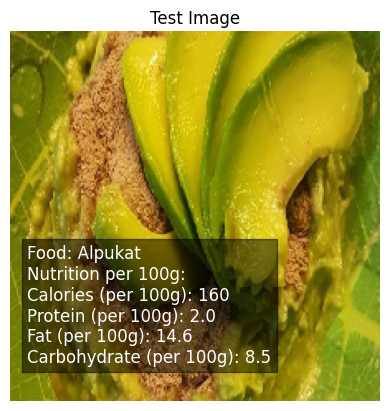

In [45]:
from prediction import predict_food
from Preprocessing import train_images

csv_path = 'Data/nutrition.csv'
model_path = 'smartbite.h5'
test_image_path = 'al.jpg'

# Step 3: Predict on a sample image
result = predict_food(test_image_path, model_path, csv_path, train_images.class_indices)

# Show the image using matplotlib
img = tf.keras.preprocessing.image.load_img(test_image_path, target_size=(224, 224))
# Add the nutrition information text inside the image
plt.imshow(img)
plt.title("Test Image")
plt.axis('off')

# Add text to the image
nutrition_text = result.replace('\n', '\n')
plt.text(10, 200, nutrition_text, fontsize=12, color='white', bbox=dict(facecolor='black', alpha=0.5))

plt.show()

In [44]:
model.save('smartbite.h5')